In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
df_ = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
df = df_.copy()

Preparing the dataset

In [4]:
#  keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['INLAND', '<1H OCEAN'])]

In [5]:
# Fill missing values with zeros.
df = df.fillna(0)

In [6]:
# Apply the log transform to median_house_value.
df['median_house_value'] = np.log1p(df['median_house_value'])

In [7]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer(sparse=True)

train_dict = df_train.drop('median_house_value', axis=1).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = df_train['median_house_value'].values

val_dict = df_val.drop('median_house_value', axis=1).to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val['median_house_value'].values

### Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

Which feature is used for splitting the data?

In [9]:
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
export_text(dt, feature_names=dv.get_feature_names())

c:\Users\PC\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'|--- ocean_proximity=<1H OCEAN <= 0.50\n|   |--- value: [11.61]\n|--- ocean_proximity=<1H OCEAN >  0.50\n|   |--- value: [12.30]\n'

### Question 2

Train a random forest model with these parameters:

n_estimators=10

random_state=1

n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

np.round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)

0.245

### Question 3

Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
    
Set random_state to 1.

Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

In [12]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

In [13]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores['rmse'] = round(df_scores['rmse'], 3)

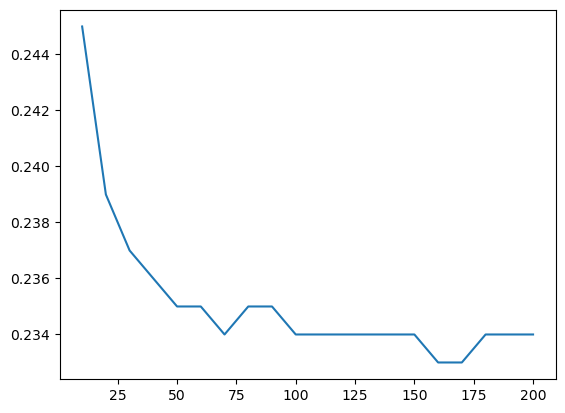

In [14]:
plt.plot(df_scores['n_estimators'], df_scores['rmse']);

In [15]:
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.236
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.235
9,100,0.234


### Question 4

Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]

For each of these values,

try different values of n_estimators from 10 till 200 (with step 10)

calculate the mean RMSE

Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

In [16]:
depth_scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        depth_scores.append((d, n, rmse))

In [17]:
df_depth_scores = pd.DataFrame(depth_scores, columns=['max_depth', 'n_estimators', 'rmse'])
df_depth_scores['rmse'] = round(df_depth_scores['rmse'], 3)

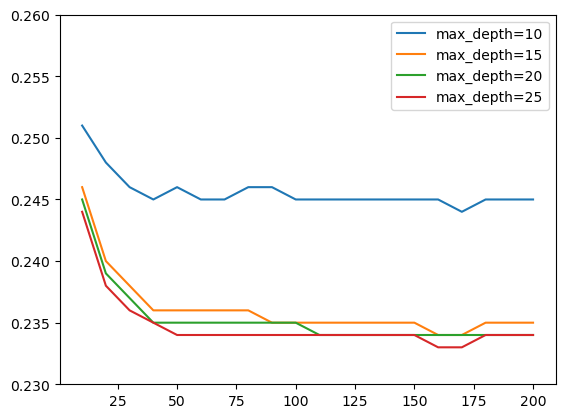

In [18]:
for d in [10, 15, 20, 25]:
    df_subset = df_depth_scores[df_depth_scores['max_depth'] == d]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label=f'max_depth={d}')
    plt.ylim(0.23, 0.26)
    plt.legend()

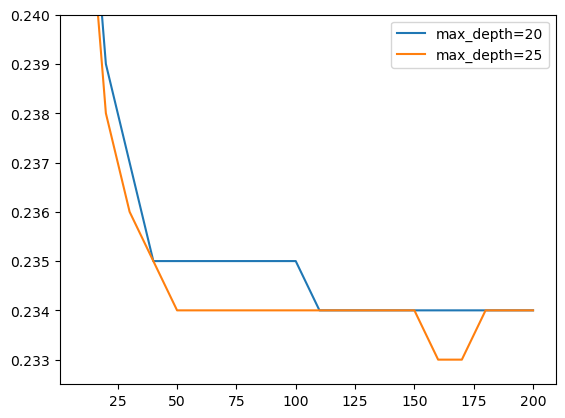

In [19]:
for d in [20, 25]:
    df_subset = df_depth_scores[df_depth_scores['max_depth'] == d]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label=f'max_depth={d}')
    plt.ylim(0.2325, 0.24)
    plt.legend()

### Question 5

For this homework question, we'll find the most important feature:

Train the model with these parameters:

n_estimators=10,

max_depth=20,

random_state=1,

n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature?

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
df_feature_importance = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'importance': rf.feature_importances_
})

In [22]:
df_feature_importance.sort_values('importance', ascending=False)

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


### Question 6

Which eta leads to the best RMSE score on the validation dataset?

0.3

0.1

Both give equal value

In [23]:
X_train_xgb = xgb.DMatrix(X_train, label=y_train)
X_val_xgb = xgb.DMatrix(X_val, label=y_val)

watchlist = [(X_train_xgb, 'train'), (X_val_xgb, 'val')]

In [24]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, X_train_xgb, num_boost_round=100, verbose_eval=5, evals=watchlist)

y_pred = model.predict(X_val_xgb)

np.round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)

[0]	train-rmse:0.44350	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21444	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24522
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23570
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23318
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225


[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13259	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11496	val-rmse:0.22861
[95]	train-rmse:0.11211	val-rmse:0.22908
[99]	train-rmse:0.10989	val-rmse:0.22862


0.229

In [25]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, X_train_xgb, num_boost_round=100, verbose_eval=5, evals=watchlist)

y_pred = model.predict(X_val_xgb)

np.round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37822	val-rmse:0.38151
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26538	val-rmse:0.28380
[20]	train-rmse:0.24512	val-rmse:0.26882
[25]	train-rmse:0.23026	val-rmse:0.25997
[30]	train-rmse:0.21887	val-rmse:0.25266
[35]	train-rmse:0.21020	val-rmse:0.24826
[40]	train-rmse:0.20392	val-rmse:0.24539
[45]	train-rmse:0.19814	val-rmse:0.24293
[50]	train-rmse:0.19215	val-rmse:0.24020
[55]	train-rmse:0.18809	val-rmse:0.23878
[60]	train-rmse:0.18457	val-rmse:0.23791
[65]	train-rmse:0.18063	val-rmse:0.23698
[70]	train-rmse:0.17741	val-rmse:0.23622
[75]	train-rmse:0.17468	val-rmse:0.23510
[80]	train-rmse:0.17242	val-rmse:0.23453
[85]	train-rmse:0.17014	val-rmse:0.23404
[90]	train-rmse:0.16797	val-rmse:0.23332
[95]	train-rmse:0.16562	val-rmse:0.23276
[99]	train-rmse:0.16323	val-rmse:0.23209


0.232